<a href="https://colab.research.google.com/github/ris0801/Generalization-DeepLearning/blob/main/CompleteCode_AdvancedProject_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captum

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import seaborn as sns
from captum.attr import IntegratedGradients
from sklearn.metrics import confusion_matrix
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


##CNN architecture as mentioned in paper

In [4]:
class SimpleCNNWithHooks(nn.Module):
    def __init__(self):
        super(SimpleCNNWithHooks, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(200)
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(200)
        # Fully connected layers
        self.fc1 = nn.Linear(200 * 7 * 7, 384)
        self.bn3 = nn.BatchNorm1d(384)
        self.fc2 = nn.Linear(384, 192)
        self.bn4 = nn.BatchNorm1d(192)
        self.fc3 = nn.Linear(192, 10)
        self.activations = {}

    def forward(self, x):

        x = x[:, :, 2:-2, 2:-2]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # Save activations
        self.activations['conv1'] = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # Save activations
        self.activations['conv2'] = x
        x = x.view(-1, 200 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


#Working with CIFAR10 data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


### Getting probability distribution
How well a machine learning model has learned to predict the correct outputs for the inputs it was trained on

In [6]:
def estimated_p_correct(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct[batch_idx * loader.batch_size:batch_idx * loader.batch_size + len(data)] = pred.eq(target).cpu().numpy().astype(int)
    return correct

### Plotting weight distribution
Visual presentation of distribution of weights

In [7]:
def plot_weight_distribution(weights, title):
    weights_flat = weights.cpu().numpy().flatten()
    plt.figure(figsize=(10, 5))
    sns.histplot(weights_flat, bins=50, kde=True)
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Visualizing weights

In [8]:
def visualize_weights(weights):
    weights = weights.cpu().numpy()
    num_filters = weights.shape[0]
    num_cols = int(np.sqrt(num_filters))
    num_rows = int(np.ceil(num_filters / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        filter_weights = weights[i, 0, :, :]

        filter_weights = (filter_weights - filter_weights.min()) / (filter_weights.max() - filter_weights.min())

        ax.imshow(filter_weights, cmap='gray')
        ax.axis('off')

    plt.show()

### Plotting attributions

**What are attributions** : How different parts of the input contribute to the model's output. For deep learning models, especially for images, attributions can highlight regions of an image that are influential in making a particular classification or prediction.



In [9]:
def calculate_and_plot_attributions(model, input_image, true_label):
    model.eval()

    ig = IntegratedGradients(model)

    attributions, delta = ig.attribute(input_image, target=true_label, return_convergence_delta=True)

    input_image_np = input_image.squeeze(0).cpu().numpy()
    attributions_np = attributions.squeeze(0).cpu().numpy()

    if input_image_np.shape[0] == 1:
        plt.imshow(input_image_np[0], cmap='gray')
    else:
        plt.imshow(input_image_np.transpose(1, 2, 0))
    plt.title("Input Image")
    plt.show()

    if attributions_np.shape[0] == 1:
        plt.imshow(attributions_np[0], cmap='gray')
    else:
        plt.imshow(attributions_np.transpose(1, 2, 0))
    plt.title("Attributions")
    plt.show()

    print("Convergence Delta:", delta)

###Function for visulazing the weights of first layer

In [10]:
def visualize_weights(weights, img_dim=(8, 8), n_rows=5, n_cols=5, channel_idx=0):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i][j]

            weight = weights[i * n_cols + j].detach().cpu().numpy()
            weight = weight.reshape(32, 8, 8)[channel_idx]

            weight = (weight - weight.min()) / (weight.max() - weight.min())

            ax.imshow(weight, cmap='gray')
            ax.axis('off')

    plt.show()

### Visualizing feature maps

In [11]:
def visualize_feature_maps(activation, num_columns=6):

    num_kernels = activation.size(1)
    num_rows = int(np.ceil(num_kernels / num_columns))
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_columns):
            if i * num_columns + j < num_kernels:
                ax = axes[i, j]
                ax.imshow(activation[0][i * num_columns + j].detach().cpu().numpy(), cmap='viridis')
                ax.axis('off')
            else:
                axes[i, j].remove()

    plt.show()

In [12]:
def calculate_mean_variance(activation):
    activation_np = activation.detach().cpu().numpy()
    mean = np.mean(activation_np)
    variance = np.var(activation_np)
    return mean, variance

In [13]:
def svcca_analysis(activations1, activations2):
    # Clone and detach tensors if they are already PyTorch tensors
    activations1 = activations1.clone().detach()
    activations2 = activations2.clone().detach()

    # Mean centering the activations
    activations1 -= torch.mean(activations1, axis=0)
    activations2 -= torch.mean(activations2, axis=0)

    # Singular Value Decomposition (SVD)
    U1, _, _ = torch.linalg.svd(activations1, full_matrices=False)
    U2, _, _ = torch.linalg.svd(activations2, full_matrices=False)

    # Ensure the dimensions are compatible for matrix multiplication
    # For instance, you may need to transpose or reshape tensors
    cca = torch.matmul(U1.T, U2)

    svcca_result = torch.diag(cca).cpu().numpy()  # Convert to numpy array if needed

    return svcca_result


In [14]:
from scipy.stats import skew, kurtosis

def calculate_skewness_kurtosis(activation):
    activation_np = activation.detach().cpu().numpy().flatten()
    skewness = skew(activation_np)
    kurtosis_val = kurtosis(activation_np)
    return skewness, kurtosis_val

In [15]:
def calculate_sparsity(activation, threshold=1e-5):
    activation_np = activation.detach().cpu().numpy()
    sparsity = np.mean(activation_np < threshold)
    return sparsity

In [16]:
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [17]:
from collections import defaultdict
def create_balanced_subset(dataset, num_per_class=100):
    class_counts = defaultdict(int)
    subset_indices = []

    for i, (_, target) in enumerate(dataset):
        if class_counts[target] < num_per_class:
            subset_indices.append(i)
            class_counts[target] += 1
            if all(count == num_per_class for count in class_counts.values()):
                break

    return torch.utils.data.Subset(dataset, subset_indices)

In [18]:
def estimated_p_correct(model, subset_loader):
    model.eval()
    correct_counts = [0] * 10  # Assuming 10 classes
    total_counts = [0] * 10

    with torch.no_grad():
        for data, target in subset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for label, prediction in zip(target, predicted):
                total_counts[label] += 1
                correct_counts[label] += (prediction == label).item()

    return correct_counts, total_counts

In [19]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total




### Working with actual data

In [20]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
import numpy as np

subset_size = 1024

np.random.seed(42)
subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)


In [22]:
from torch.utils.data import Subset

# Subset for actual data
actual_subset = Subset(train_dataset, subset_indices)
actual_loader = torch.utils.data.DataLoader(actual_subset, batch_size=64, shuffle=True)

Statistics of the weights For Conv1:
Mean: 0.0003958973684348166
Standard Deviation: 0.06621358543634415
Minimum: -0.11546651273965836
Maximum: 0.11545543372631073


Statistics of the weights for Conv2:
Mean: -6.056421170796966e-06
Standard Deviation: 0.008162638172507286
Minimum: -0.014142122119665146
Maximum: 0.014142111875116825


Files already downloaded and verified


Analysis after epoch 1


Statistics of the weights For Conv1:
Mean: -0.0005444005946628749
Standard Deviation: 0.0704926922917366
Minimum: -0.18757180869579315
Maximum: 0.17030572891235352


Statistics of the weights for Conv2:
Mean: -0.0004089941503480077
Standard Deviation: 0.009341784752905369
Minimum: -0.04180259257555008
Maximum: 0.057299673557281494




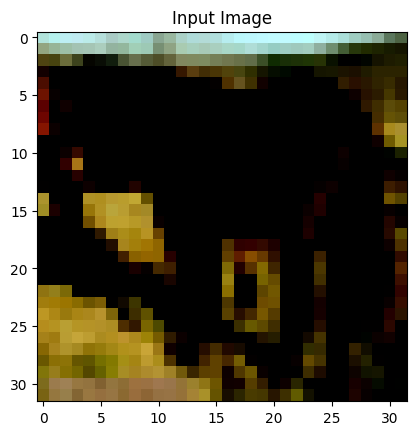

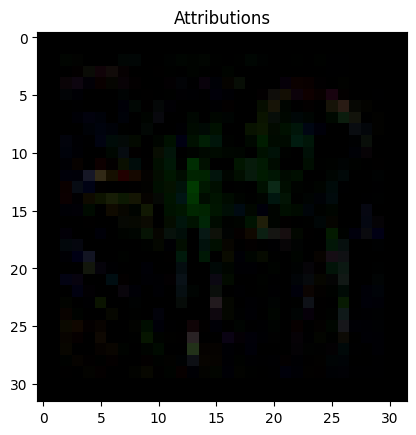

Convergence Delta: tensor([-0.0373], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.841019332408905
Variance: 0.682922899723053
Skewness: 1.282219200773904
Kurtosis: 2.127491014635302
Sparsity: 0.20365353954081633


Analysis for layer: conv2
Mean: 0.7899178266525269
Variance: 0.5594308376312256
Skewness: 1.1549964997041198
Kurtosis: 2.16089913277398
Sparsity: 0.21919005102040817








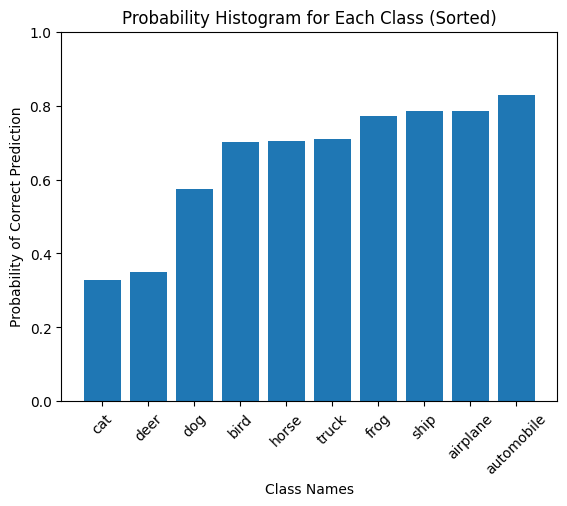



Accuracy on the test set after the final epoch: 65.40%


Analysis after epoch 5


Statistics of the weights For Conv1:
Mean: -0.0008924021385610104
Standard Deviation: 0.08562512695789337
Minimum: -0.31438907980918884
Maximum: 0.2976857125759125


Statistics of the weights for Conv2:
Mean: -0.000860365224070847
Standard Deviation: 0.012452863156795502
Minimum: -0.06935776770114899
Maximum: 0.11597190052270889




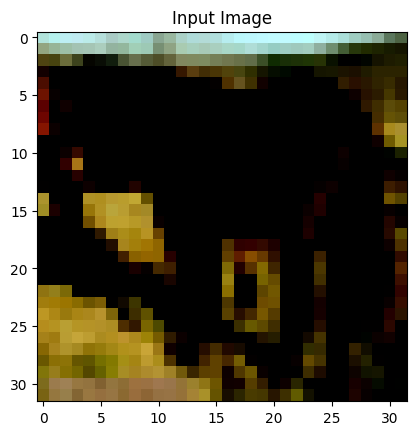

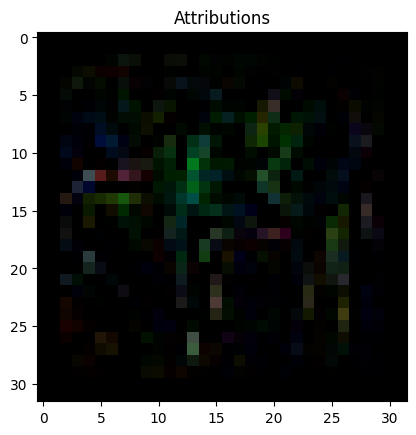

Convergence Delta: tensor([-0.1499], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.786877453327179
Variance: 0.6517781019210815
Skewness: 1.5292723813073525
Kurtosis: 3.5314424330109153
Sparsity: 0.1997002551020408


Analysis for layer: conv2
Mean: 0.7314185500144958
Variance: 0.43073511123657227
Skewness: 1.0980925918470763
Kurtosis: 2.249323217590243
Sparsity: 0.19566485969387756








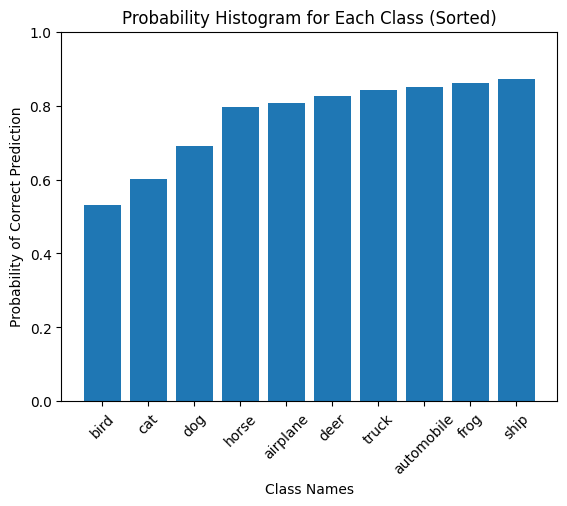



Accuracy on the test set after the final epoch: 76.79%


Analysis after epoch 10


Statistics of the weights For Conv1:
Mean: -0.0006055982084944844
Standard Deviation: 0.09628509730100632
Minimum: -0.39246755838394165
Maximum: 0.37143656611442566


Statistics of the weights for Conv2:
Mean: -0.001180103630758822
Standard Deviation: 0.01515351515263319
Minimum: -0.10337129235267639
Maximum: 0.15455642342567444




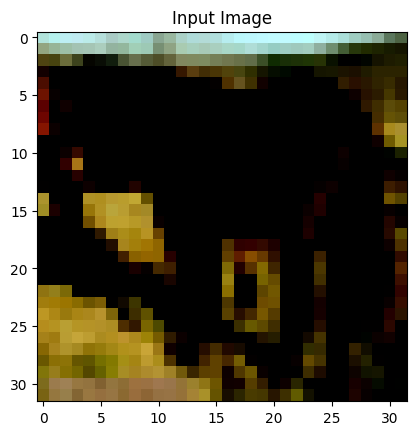

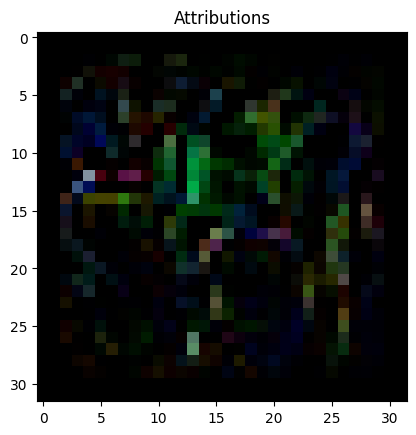

Convergence Delta: tensor([0.2034], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7831276655197144
Variance: 0.7279755473136902
Skewness: 1.771759953029075
Kurtosis: 5.3530992456808555
Sparsity: 0.21902941645408164


Analysis for layer: conv2
Mean: 0.713776707649231
Variance: 0.4213339686393738
Skewness: 1.2304271929165893
Kurtosis: 3.0408238304701083
Sparsity: 0.19541294642857143








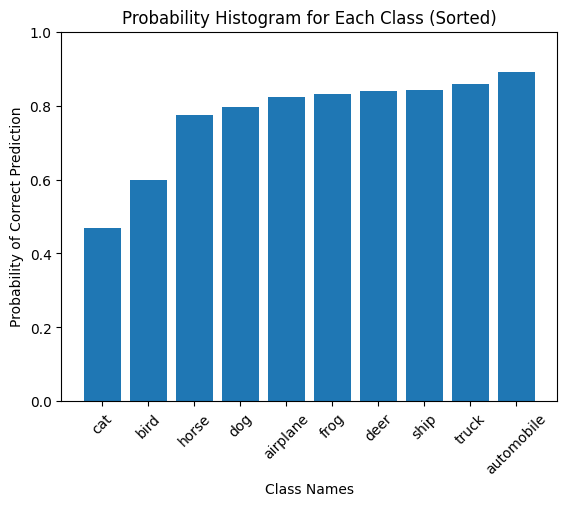



Accuracy on the test set after the final epoch: 77.24%


Analysis after epoch 15


Statistics of the weights For Conv1:
Mean: -0.0007573208422400057
Standard Deviation: 0.10132022947072983
Minimum: -0.402433305978775
Maximum: 0.40610888600349426


Statistics of the weights for Conv2:
Mean: -0.0013856618897989392
Standard Deviation: 0.016514059156179428
Minimum: -0.12486392259597778
Maximum: 0.17024968564510345




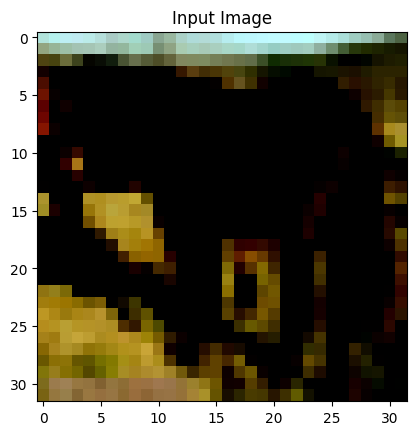

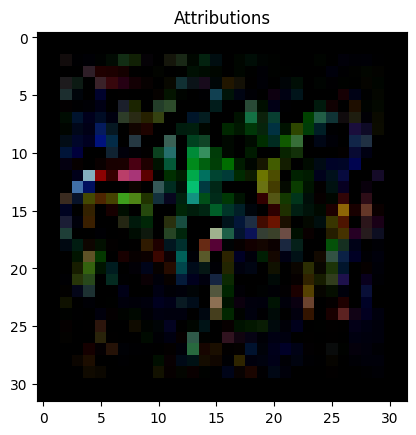

Convergence Delta: tensor([-0.2343], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8229407072067261
Variance: 0.6909694075584412
Skewness: 1.60131354355058
Kurtosis: 4.123093710826706
Sparsity: 0.18582748724489795


Analysis for layer: conv2
Mean: 0.6423120498657227
Variance: 0.3732278048992157
Skewness: 1.152088571520204
Kurtosis: 1.8965196916399458
Sparsity: 0.22041932397959182








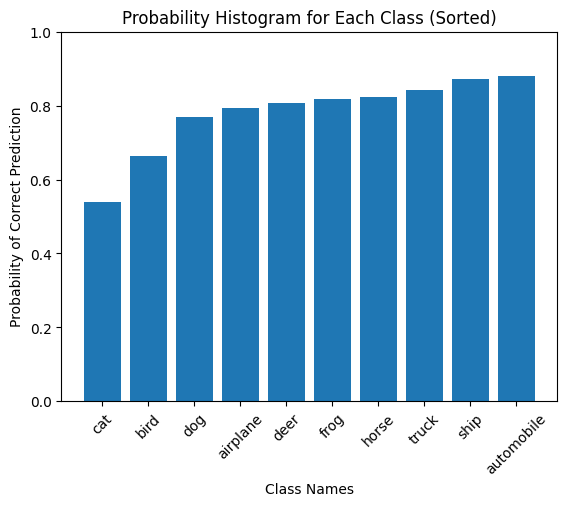



Accuracy on the test set after the final epoch: 78.09%


Analysis after epoch 20


Statistics of the weights For Conv1:
Mean: -0.0006693348987028003
Standard Deviation: 0.10145959258079529
Minimum: -0.40804699063301086
Maximum: 0.40718865394592285


Statistics of the weights for Conv2:
Mean: -0.001363486284390092
Standard Deviation: 0.016554342582821846
Minimum: -0.12439094483852386
Maximum: 0.17112897336483002




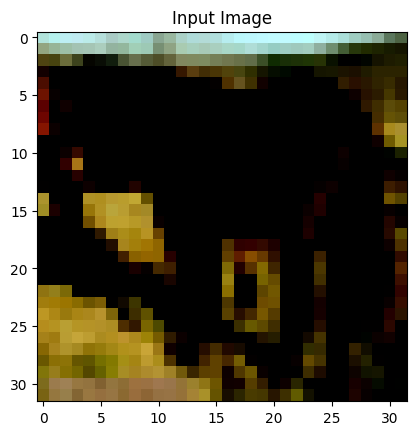

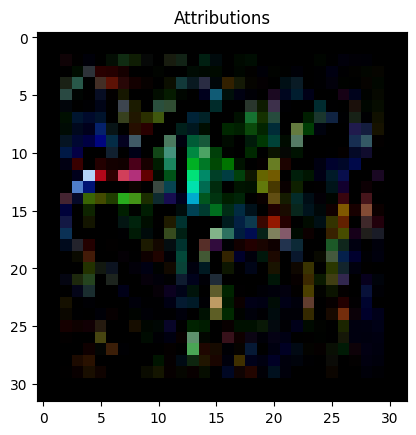

Convergence Delta: tensor([0.0612], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7948672771453857
Variance: 0.7342185974121094
Skewness: 1.7533636691976553
Kurtosis: 5.124157739132825
Sparsity: 0.20993104272959184


Analysis for layer: conv2
Mean: 0.6657378077507019
Variance: 0.3784725069999695
Skewness: 1.187380634551112
Kurtosis: 2.5718568923397047
Sparsity: 0.20826371173469388








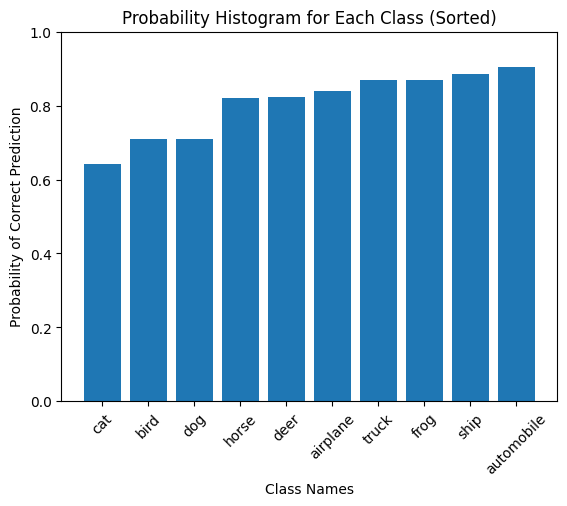



Accuracy on the test set after the final epoch: 80.74%


Analysis after epoch 25


Statistics of the weights For Conv1:
Mean: -0.0007308699423447251
Standard Deviation: 0.10148589313030243
Minimum: -0.4081422984600067
Maximum: 0.4088691174983978


Statistics of the weights for Conv2:
Mean: -0.0013776617124676704
Standard Deviation: 0.016560547053813934
Minimum: -0.12347667664289474
Maximum: 0.16938893496990204




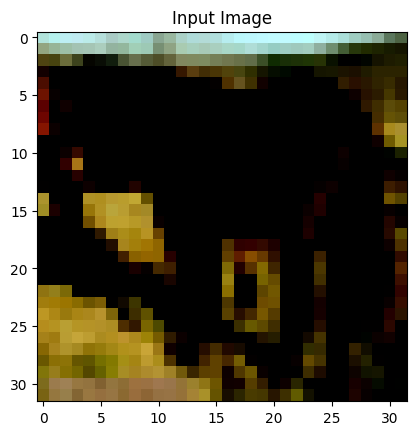

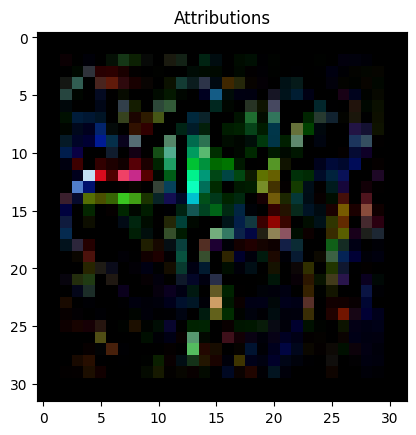

Convergence Delta: tensor([0.0246], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7696229815483093
Variance: 0.6968584656715393
Skewness: 1.893637028651682
Kurtosis: 5.963375616347227
Sparsity: 0.20463647959183673


Analysis for layer: conv2
Mean: 0.6624009609222412
Variance: 0.35440874099731445
Skewness: 1.1521429417175535
Kurtosis: 2.5220340164691883
Sparsity: 0.19504783163265307








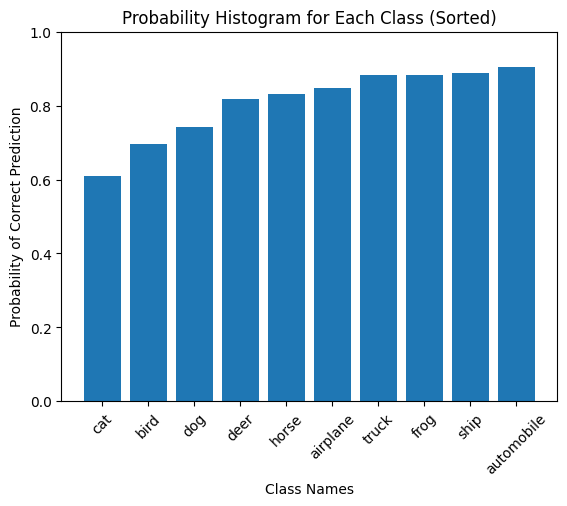



Accuracy on the test set after the final epoch: 81.00%


Analysis after epoch 30


Statistics of the weights For Conv1:
Mean: -0.000699066324159503
Standard Deviation: 0.10153667628765106
Minimum: -0.4095522463321686
Maximum: 0.4070408344268799


Statistics of the weights for Conv2:
Mean: -0.0013686857419088483
Standard Deviation: 0.01657651551067829
Minimum: -0.12315636873245239
Maximum: 0.17068979144096375




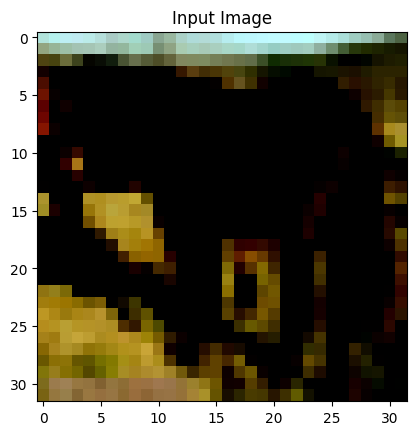

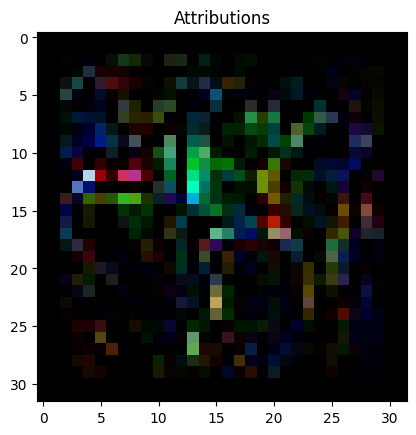

Convergence Delta: tensor([0.1061], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8464311361312866
Variance: 0.7950613498687744
Skewness: 1.6881035075703674
Kurtosis: 4.353475661178431
Sparsity: 0.19497927295918369


Analysis for layer: conv2
Mean: 0.6779075860977173
Variance: 0.4086049497127533
Skewness: 1.1560658377474342
Kurtosis: 1.9926383820541593
Sparsity: 0.21656728316326532








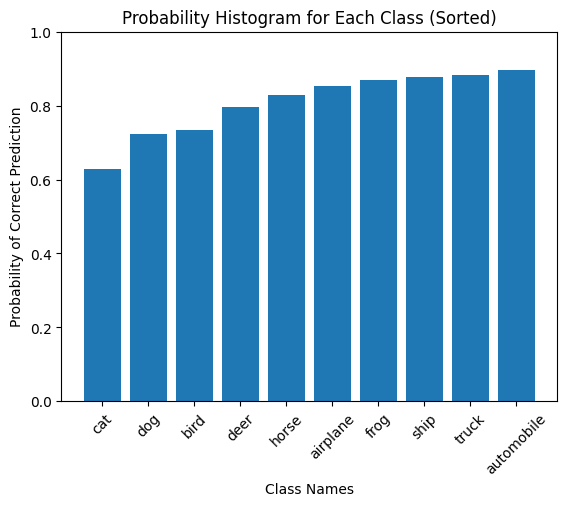



Accuracy on the test set after the final epoch: 80.87%


In [23]:
num_initializations = 1

for _ in range(num_initializations):
    sample_data, sample_target = next(iter(train_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model1 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model1.conv1.weight.data
    # plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")

    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model1.conv2.weight.data
    # plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")

    weights = model1.conv1.weight.data
    weightsConv2 = model1.conv2.weight.data

    mean = weights.mean().item()
    std = weights.std().item()
    min_val = weights.min().item()
    max_val = weights.max().item()

    print("Statistics of the weights For Conv1:")
    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Minimum:", min_val)
    print("Maximum:", max_val)
    print("\n")

    mean = weightsConv2.mean().item()
    std = weightsConv2.std().item()
    min_val = weightsConv2.min().item()
    max_val = weightsConv2.max().item()

    print("Statistics of the weights for Conv2:")
    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Minimum:", min_val)
    print("Maximum:", max_val)
    print("\n")

    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


    for epoch in range(30):
      model1.train()
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model1(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if epoch==0 or (epoch+1)%10==0:
        # Save activations
        model1.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in actual_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model1(data)
                for layer_name, activation in model1.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'model1_activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
        model1.eval()
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        # torch.save(model1.state_dict(), f'model_1_epoch_{epoch+1}.pth')

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")
        print("\n")

        # Weight distribution and statistics
        weights = model1.conv1.weight.data
        # plot_weight_distribution(weights, f"Weight Distribution Conv1 - Epoch {epoch + 1}")

        weightsConv2 = model1.conv2.weight.data
        # plot_weight_distribution(weightsConv2, f"Weight Distribution Conv2 - Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights For Conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)
        print("\n")

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for Conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)
        print("\n")

        # Attribution Analysis
        calculate_and_plot_attributions(model1, input_image, true_label)

        # Activation Analysis
        images, labels = next(iter(train_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model1(images)
        for layer_name, activation in model1.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        # val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model1, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()
        print("\n")
        print("\n")

        # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)

        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]

        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()

        accuracy = calculate_accuracy(model1, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')

      scheduler.step()


###Observations from weight statistics:
For conv1:

1. This slight shift in mean doesn't indicate a strong bias in the weight updates.
2. The standard deviation increases over time, from approximately 0.0666 to 0.1013. This suggests that the network's weights are spreading out and the network is becoming more confident in the features it is learning.
3. The minimum and maximum weight values become more extreme as training progresses. This widening of the range could imply that the network is increasingly fitting to the data; however, if these changes are too extreme, it could also indicate the beginning of overfitting, where the model starts to learn noise in the data.

For conv2:

1. The standard deviation for Conv2 increases from about 0.0082 to 0.0164, which is a doubling in spread. This is a more pronounced increase than in Conv1, possibly indicating that this layer is learning more detailed features or patterns.

2. The range of the weights (from minimum to maximum) increases significantly. This is particularly notable for the maximum weight values, which suggests that the network is assigning greater importance to certain features.


Maintaing probability distribution of correct predictions

##Observation from weight plot

Symmetrical - Balance of both positive and negative weights, indicative of feature extraction.

Skew - Specialized neurons responding to speicific features

There is too much balance in postive and negative weights

Weight statistics of data

###Observations from weight statistics
1. The mean weight values being close to zero in all cases is a typical result of weight initialization methods
2. The slightly wider range of weight values for the real CIFAR-10 dataset might indicate that the model is able to find more useful features in the structured data
3.The narrower range (randomized labels and inputs) could imply that the model is less confident about the random data patterns compared to the real data. This could be because the noise doesn’t provide consistent gradients during training, which limits the extent to which weights can grow or shrink.

Plotting atrributions for original data

###Observation
There is some highlighed regions in image, suggesting it's learning features to classify true labels

##Feature visualization

Setting model to evaluation mode

**Mean :** The mean of activations is a measure of the central tendency.

**Variance :** Variance measures how much the activations differ from the mean.

**Positive Skewness:** When the skewness is positive, the distribution's tail on the right-hand side (the higher end of values) is longer or fatter than the left-hand side. This suggests that there is a subset of the data with very high values that are pulling the average to the right.

**Kurtosis:** A kurtosis greater than zero, known as leptokurtic, indicates a distribution with heavy tails and a sharp peak. In the context of neuron activations, this means there are more outliers with extremely high or low activations than would be expected in a normal distribution. This could suggest that certain patterns in the input data result in very strong activations in some neurons, possibly denoting features of interest.

##Random input

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [25]:
formatted_data = np.transpose(train_dataset.data, (0, 3, 1, 2))  # [N, 3, 32, 32]
randX_data = torch.randn_like(torch.tensor(formatted_data, dtype=torch.float)) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, torch.tensor(train_dataset.targets))
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [26]:
# Subset for random inputs
randX_data_subset = randX_data[subset_indices]
randX_targets_subset = torch.tensor(train_dataset.targets)[subset_indices]
randX_subset = torch.utils.data.TensorDataset(randX_data_subset, randX_targets_subset)
randX_subset_loader = torch.utils.data.DataLoader(randX_subset, batch_size=64, shuffle=True)

Files already downloaded and verified


Analysis after epoch 1
Statistics of the weights for conv1:
Mean: 0.0007419827743433416
Standard Deviation: 0.06761722266674042
Minimum: -0.13862113654613495
Maximum: 0.13944454491138458
Statistics of the weights for conv2:
Mean: -7.020260818535462e-05
Standard Deviation: 0.009566167369484901
Minimum: -0.04299520328640938
Maximum: 0.04077979922294617


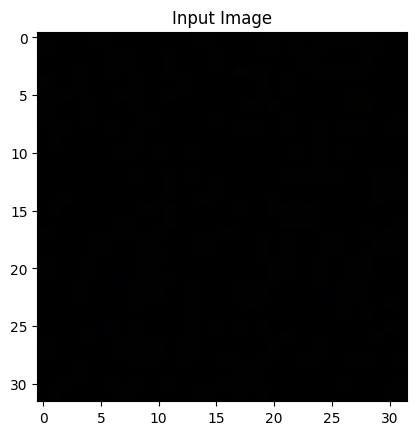

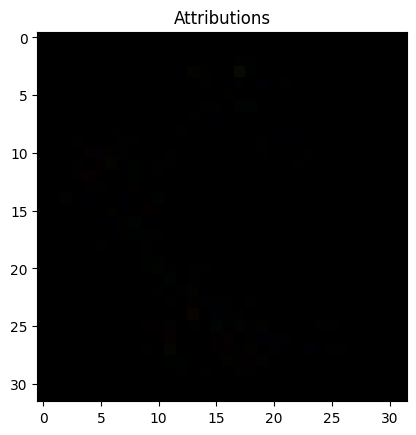

Convergence Delta: tensor([0.0077], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8289713859558105
Variance: 0.12976738810539246
Skewness: 0.42457581033224884
Kurtosis: 0.32675027382678756
Sparsity: 0.004533641581632653


Analysis for layer: conv2
Mean: 0.7858669757843018
Variance: 0.5341252684593201
Skewness: 0.7369009641683727
Kurtosis: -0.16429551759807826
Sparsity: 0.2686894132653061


Files already downloaded and verified






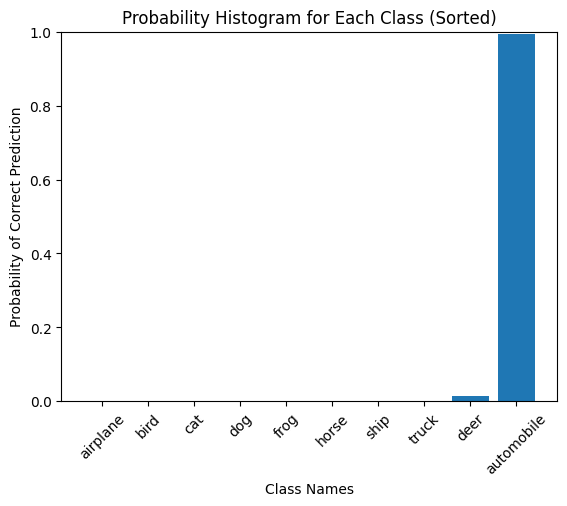



Accuracy on the test set after the final epoch: 10.08%


Analysis after epoch 5
Statistics of the weights for conv1:
Mean: -8.02429422037676e-05
Standard Deviation: 0.10223683714866638
Minimum: -0.28416869044303894
Maximum: 0.2888530492782593
Statistics of the weights for conv2:
Mean: -0.00015336324577219784
Standard Deviation: 0.023835279047489166
Minimum: -0.1354166865348816
Maximum: 0.1423734724521637


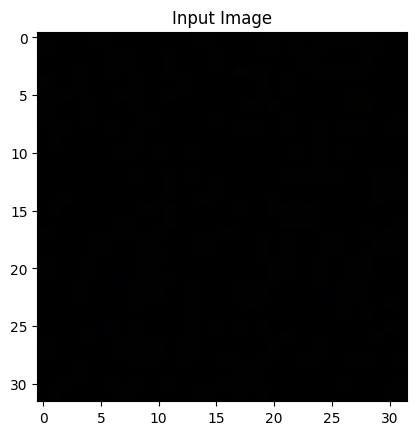

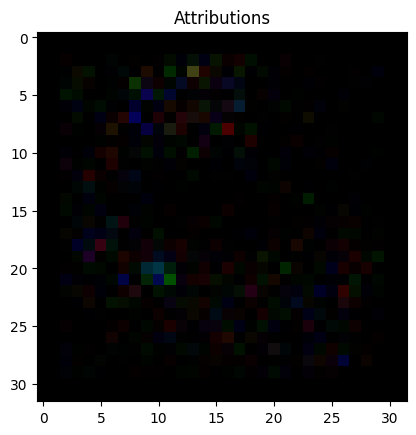

Convergence Delta: tensor([-0.3031], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.0399216413497925
Variance: 0.1974451243877411
Skewness: 0.4669198452823064
Kurtosis: 0.3679890722125734
Sparsity: 0.003180404974489796


Analysis for layer: conv2
Mean: 0.9194054007530212
Variance: 0.640038788318634
Skewness: 0.62547979735767
Kurtosis: -0.36708781139133073
Sparsity: 0.21455197704081633


Files already downloaded and verified






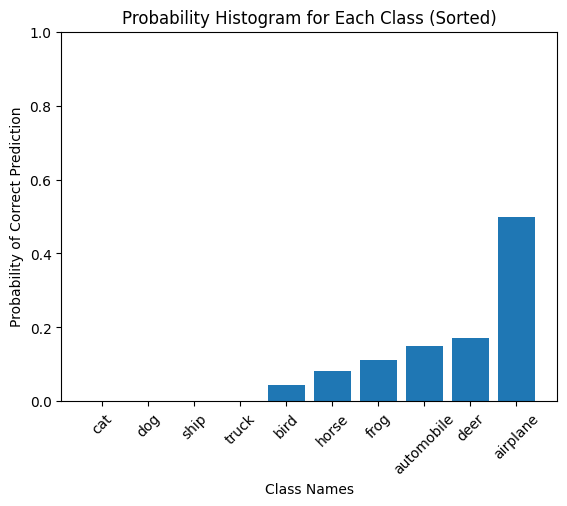



Accuracy on the test set after the final epoch: 10.61%


Analysis after epoch 10
Statistics of the weights for conv1:
Mean: 4.457743852981366e-05
Standard Deviation: 0.13583648204803467
Minimum: -0.3759304881095886
Maximum: 0.36045899987220764
Statistics of the weights for conv2:
Mean: -0.00021097029093652964
Standard Deviation: 0.033285558223724365
Minimum: -0.17937882244586945
Maximum: 0.17311114072799683


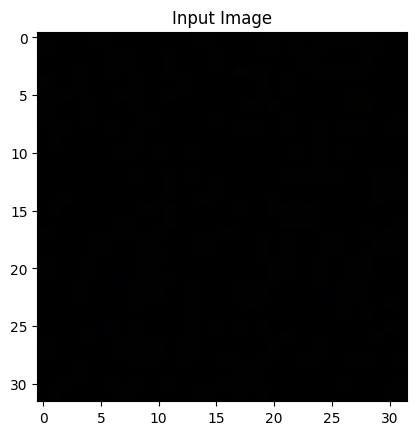

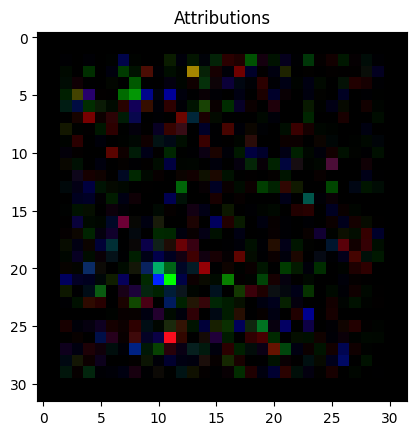

Convergence Delta: tensor([-0.1847], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1270637512207031
Variance: 0.2463805377483368
Skewness: 0.4804559986520455
Kurtosis: 0.39112996993364035
Sparsity: 0.004078443877551021


Analysis for layer: conv2
Mean: 0.9908692240715027
Variance: 0.6172460913658142
Skewness: 0.5194015809749833
Kurtosis: -0.4477924729863383
Sparsity: 0.16178571428571428


Files already downloaded and verified






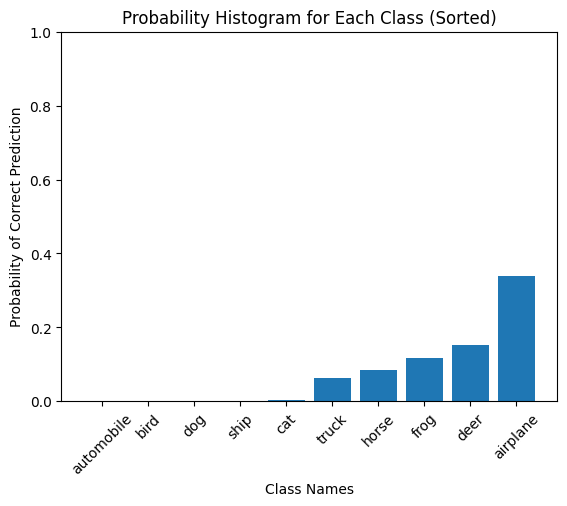



Accuracy on the test set after the final epoch: 7.60%


Analysis after epoch 15
Statistics of the weights for conv1:
Mean: 7.545026164734736e-05
Standard Deviation: 0.13687705993652344
Minimum: -0.38582465052604675
Maximum: 0.3698464334011078
Statistics of the weights for conv2:
Mean: -0.00022621839889325202
Standard Deviation: 0.03357309475541115
Minimum: -0.17691655457019806
Maximum: 0.17346006631851196


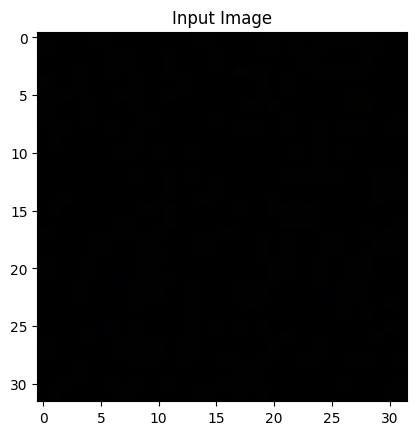

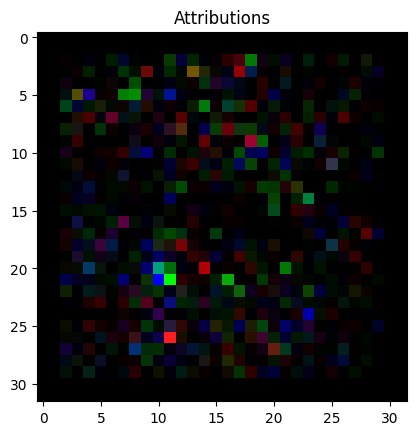

Convergence Delta: tensor([-0.3949], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1265969276428223
Variance: 0.24548354744911194
Skewness: 0.4845894072963059
Kurtosis: 0.3848018844494425
Sparsity: 0.003867984693877551


Analysis for layer: conv2
Mean: 1.0005112886428833
Variance: 0.6189545392990112
Skewness: 0.5193584571393812
Kurtosis: -0.45603525772549913
Sparsity: 0.1507780612244898


Files already downloaded and verified






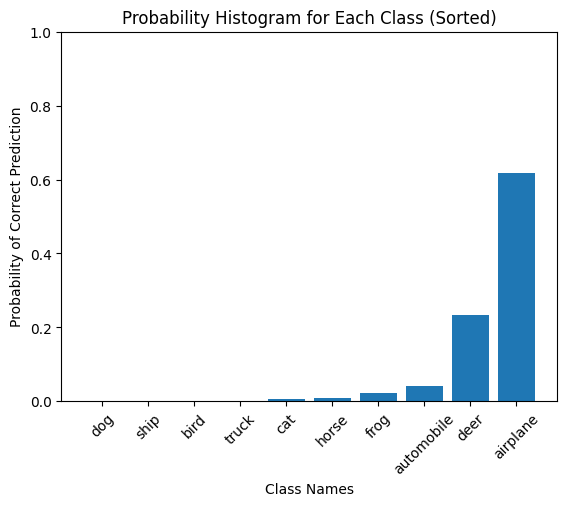



Accuracy on the test set after the final epoch: 9.34%


Analysis after epoch 20
Statistics of the weights for conv1:
Mean: 7.249304326251149e-05
Standard Deviation: 0.13688009977340698
Minimum: -0.3853887915611267
Maximum: 0.36915215849876404
Statistics of the weights for conv2:
Mean: -0.00023147180036175996
Standard Deviation: 0.033573977649211884
Minimum: -0.17732499539852142
Maximum: 0.17395330965518951


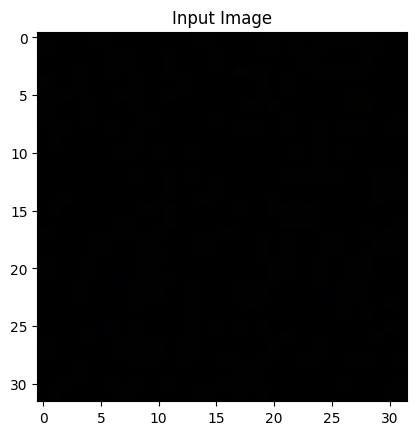

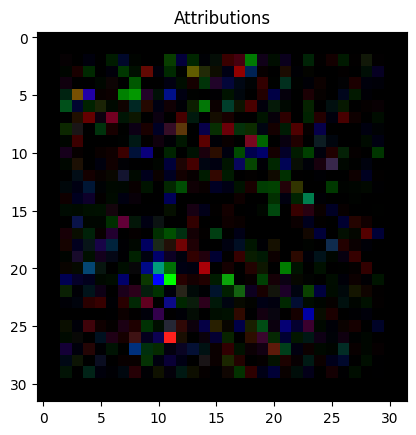

Convergence Delta: tensor([-0.1522], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1282063722610474
Variance: 0.2467745840549469
Skewness: 0.48476224149643315
Kurtosis: 0.39959490694749755
Sparsity: 0.0040178571428571425


Analysis for layer: conv2
Mean: 1.002988576889038
Variance: 0.6207979321479797
Skewness: 0.5198282586067323
Kurtosis: -0.4631571059209998
Sparsity: 0.14875956632653062


Files already downloaded and verified






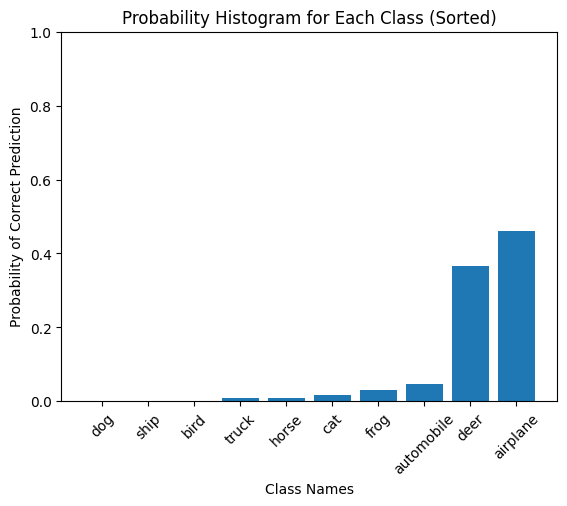



Accuracy on the test set after the final epoch: 9.41%


Analysis after epoch 25
Statistics of the weights for conv1:
Mean: 8.052104385569692e-05
Standard Deviation: 0.13688093423843384
Minimum: -0.3847752809524536
Maximum: 0.3682232201099396
Statistics of the weights for conv2:
Mean: -0.0002386058768024668
Standard Deviation: 0.0335741825401783
Minimum: -0.1774115264415741
Maximum: 0.17381884157657623


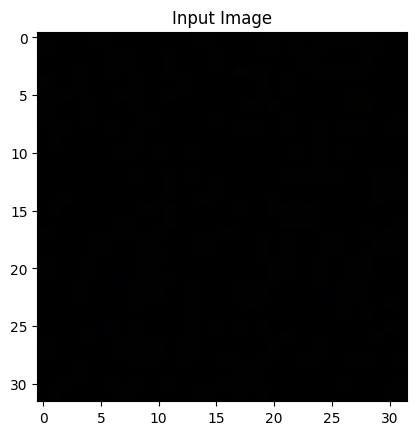

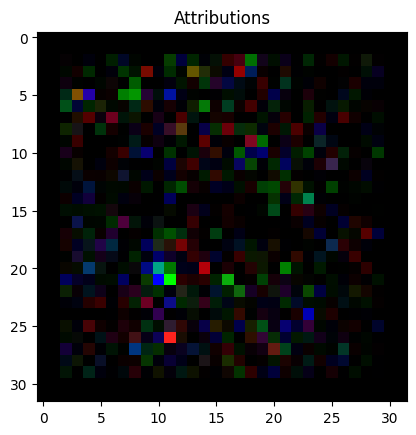

Convergence Delta: tensor([-0.1433], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.122667670249939
Variance: 0.24459442496299744
Skewness: 0.47756984580456996
Kurtosis: 0.3788060158524913
Sparsity: 0.004050143494897959


Analysis for layer: conv2
Mean: 1.0044161081314087
Variance: 0.6179311871528625
Skewness: 0.5256749296256045
Kurtosis: -0.4433316368942366
Sparsity: 0.14520089285714285


Files already downloaded and verified






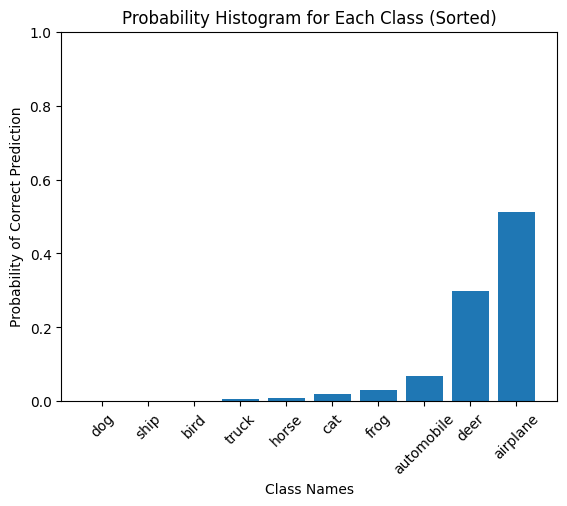



Accuracy on the test set after the final epoch: 9.49%


Analysis after epoch 30
Statistics of the weights for conv1:
Mean: 6.117172597441822e-05
Standard Deviation: 0.13689042627811432
Minimum: -0.3851509392261505
Maximum: 0.36721572279930115
Statistics of the weights for conv2:
Mean: -0.000239532848354429
Standard Deviation: 0.03357681259512901
Minimum: -0.17733269929885864
Maximum: 0.17406585812568665


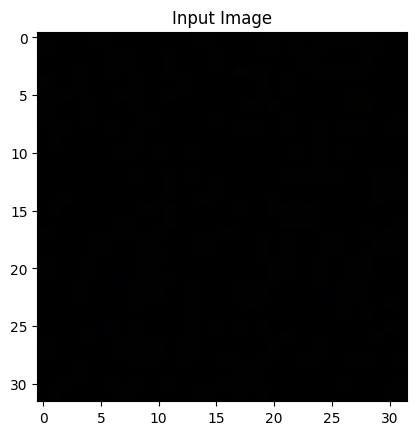

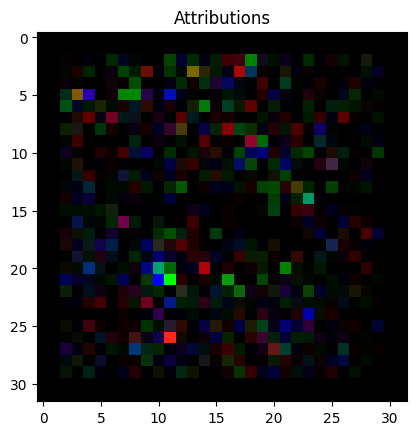

Convergence Delta: tensor([0.1841], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1287037134170532
Variance: 0.24718642234802246
Skewness: 0.48179390704095265
Kurtosis: 0.3836522779791145
Sparsity: 0.003926179846938775


Analysis for layer: conv2
Mean: 1.0068761110305786
Variance: 0.624271035194397
Skewness: 0.5163839474153791
Kurtosis: -0.4716187917179244
Sparsity: 0.14846460459183675


Files already downloaded and verified






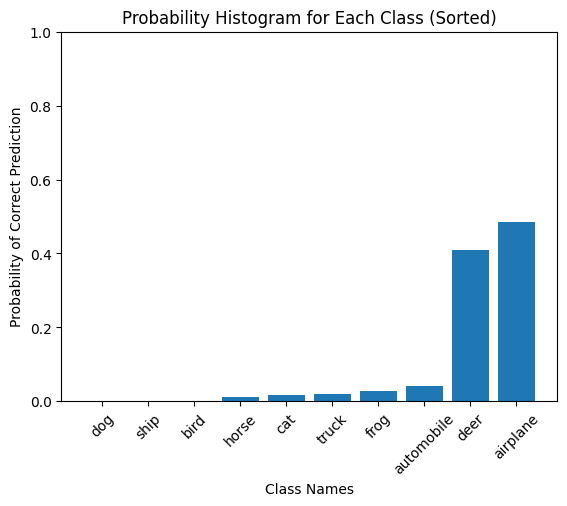



Accuracy on the test set after the final epoch: 10.14%


In [27]:
num_initializations = 1
# all_p_corrects_randx = np.zeros(len(randX_dataset))

for _ in range(num_initializations):

    sample_data, sample_target = next(iter(randX_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model2 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model2.conv1.weight.data
    # plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")
    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model2.conv2.weight.data
    # plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")
    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


    for epoch in range(30):
      model2.train()
      for data, target in randX_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model2(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if (epoch + 1)%10==0 or epoch==0:
        # Save activations
        model2.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in randX_subset_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model1(data)
                for layer_name, activation in model2.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'model2_activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        #torch.save(model2.state_dict(), f'model_2_epoch_{epoch+1}.pth')

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")

        # Weight distribution and statistics
        weights = model2.conv1.weight.data
        # plot_weight_distribution(weights, f"Weight Distribution Conv 1 - Epoch {epoch + 1}")

        weightsConv2 = model2.conv2.weight.data
        # plot_weight_distribution(weightsConv2, f"Weight Distribution Conv 2 - Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights for conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        # Attribution Analysis
        calculate_and_plot_attributions(model2, input_image, true_label)

        # Activation Analysis
        model2.eval()
        images, labels = next(iter(randX_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model2(images)
        for layer_name, activation in model2.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model2, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()

        print("\n")
        print("\n")

         # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)

        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]
        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()
        accuracy = calculate_accuracy(model2, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')
      scheduler.step()

##Random labels

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [29]:
formatted_data_tensor = torch.tensor(np.transpose(train_dataset.data, (0, 3, 1, 2)), dtype=torch.float) / 255.

randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)

randY_dataset = torch.utils.data.TensorDataset(formatted_data_tensor, randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [30]:
# Subset for random labels
randY_data_subset = formatted_data_tensor[subset_indices]
randY_labels_subset = torch.tensor(np.random.randint(0, 10, subset_size), dtype=torch.long)
randY_subset = torch.utils.data.TensorDataset(randY_data_subset, randY_labels_subset)
randY_subset_loader = torch.utils.data.DataLoader(randY_subset, batch_size=64, shuffle=True)


Files already downloaded and verified
Analysis after epoch 1
Statistics of the weights for conv1:
Mean: 0.0004676897660829127
Standard Deviation: 0.06673313677310944
Minimum: -0.1248641088604927
Maximum: 0.12069359421730042
Statistics of the weights for conv2:
Mean: 4.00763274228666e-05
Standard Deviation: 0.008372098207473755
Minimum: -0.022698549553751945
Maximum: 0.021598543971776962


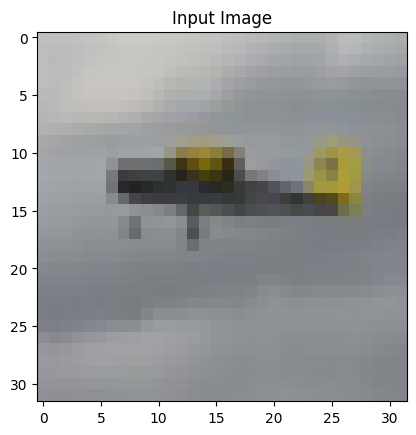

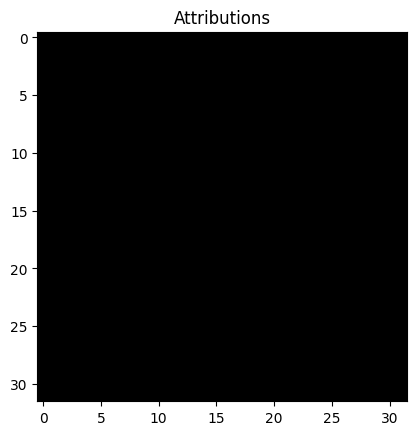

Convergence Delta: tensor([0.0056], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7156779766082764
Variance: 0.5392430424690247
Skewness: 1.1149992798636945
Kurtosis: 1.2489272800160158
Sparsity: 0.26893813775510206


Analysis for layer: conv2
Mean: 0.746039867401123
Variance: 0.5965394973754883
Skewness: 1.1545873579493566
Kurtosis: 1.469124490256271
Sparsity: 0.28355389030612244


Files already downloaded and verified






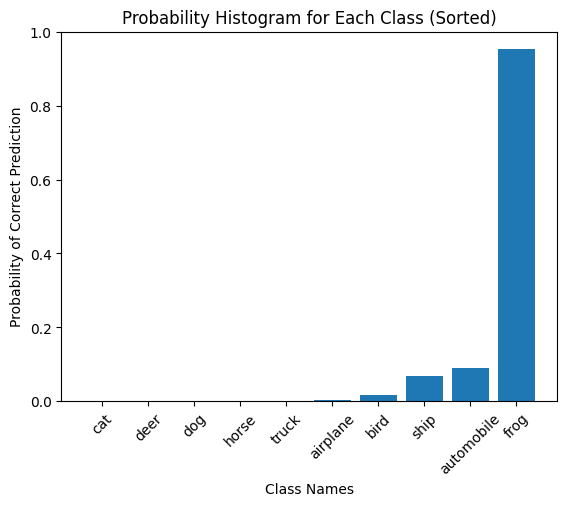



Accuracy on the test set after the final epoch: 11.35%
Analysis after epoch 5
Statistics of the weights for conv1:
Mean: -0.0003091913240496069
Standard Deviation: 0.0667906329035759
Minimum: -0.12744833528995514
Maximum: 0.12243872880935669
Statistics of the weights for conv2:
Mean: -9.046521154232323e-05
Standard Deviation: 0.008441888727247715
Minimum: -0.022927481681108475
Maximum: 0.025185950100421906


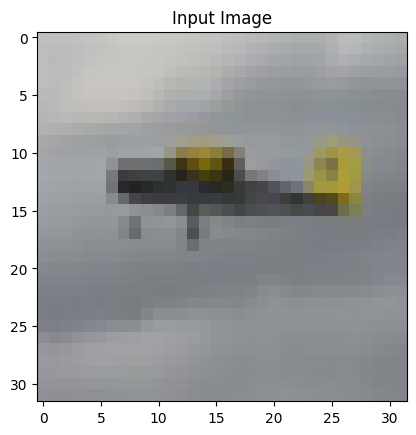

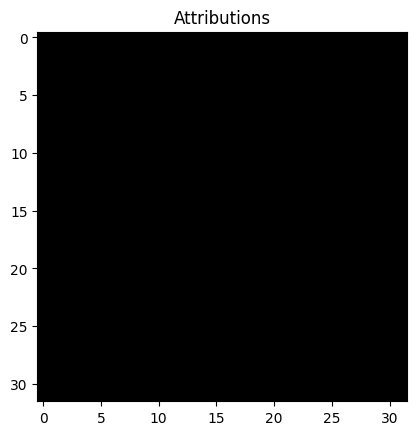

Convergence Delta: tensor([-0.0005], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7534691095352173
Variance: 0.5758360028266907
Skewness: 1.2345282936282234
Kurtosis: 1.9408553362116434
Sparsity: 0.2352164381377551


Analysis for layer: conv2
Mean: 0.8539856672286987
Variance: 0.6244731545448303
Skewness: 1.0081856417799646
Kurtosis: 1.1904011812202997
Sparsity: 0.21427933673469388


Files already downloaded and verified






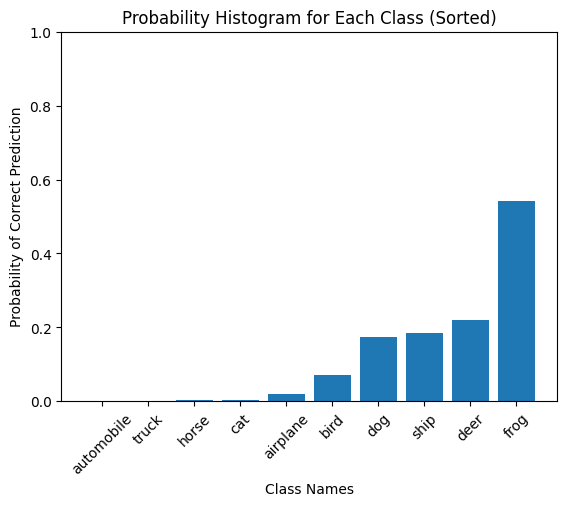



Accuracy on the test set after the final epoch: 12.20%
Analysis after epoch 10
Statistics of the weights for conv1:
Mean: -0.0003943887713830918
Standard Deviation: 0.06841428577899933
Minimum: -0.1503831446170807
Maximum: 0.15226846933364868
Statistics of the weights for conv2:
Mean: -0.00038279613363556564
Standard Deviation: 0.009853369556367397
Minimum: -0.046656470745801926
Maximum: 0.05546058341860771


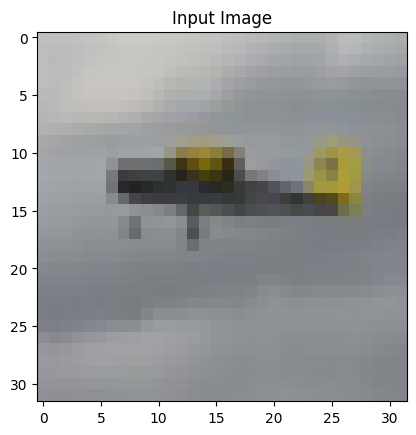

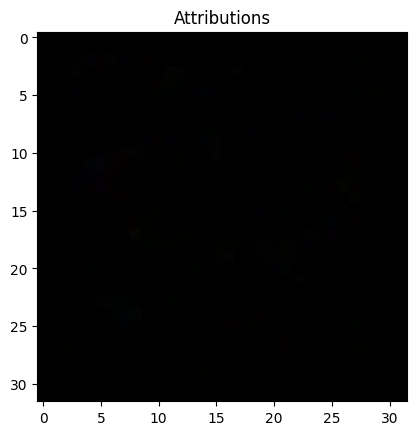

Convergence Delta: tensor([-0.0147], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7861562371253967
Variance: 0.5892602205276489
Skewness: 1.2092685347722327
Kurtosis: 1.838840814603265
Sparsity: 0.21698142538265305


Analysis for layer: conv2
Mean: 0.8971790075302124
Variance: 0.576951801776886
Skewness: 0.866453058313868
Kurtosis: 0.972876823855453
Sparsity: 0.17478635204081633


Files already downloaded and verified






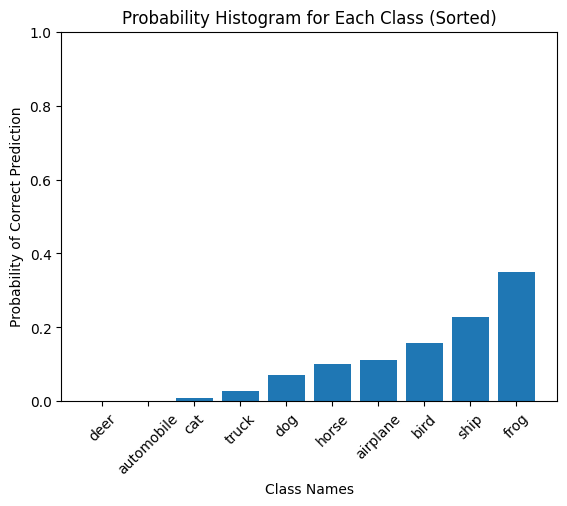



Accuracy on the test set after the final epoch: 10.57%
Analysis after epoch 15
Statistics of the weights for conv1:
Mean: -0.0007193195051513612
Standard Deviation: 0.08226659148931503
Minimum: -0.2571124732494354
Maximum: 0.2791464030742645
Statistics of the weights for conv2:
Mean: -0.0009936714777722955
Standard Deviation: 0.016201620921492577
Minimum: -0.10849901288747787
Maximum: 0.12709617614746094


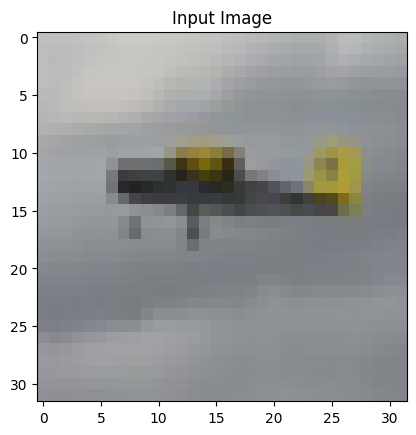

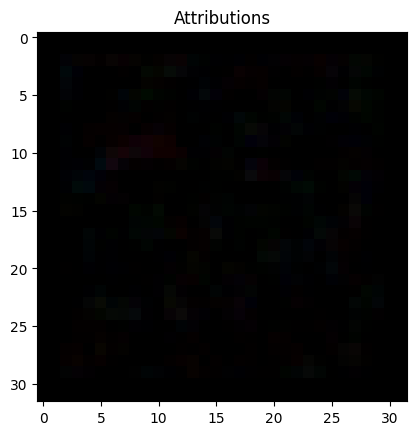

Convergence Delta: tensor([0.0518], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7946379780769348
Variance: 0.6031972765922546
Skewness: 1.3044345899118275
Kurtosis: 2.529264396425151
Sparsity: 0.21255460778061225


Analysis for layer: conv2
Mean: 0.8404375314712524
Variance: 0.5107163786888123
Skewness: 0.8774861674466224
Kurtosis: 0.9035149133403646
Sparsity: 0.17205994897959184


Files already downloaded and verified






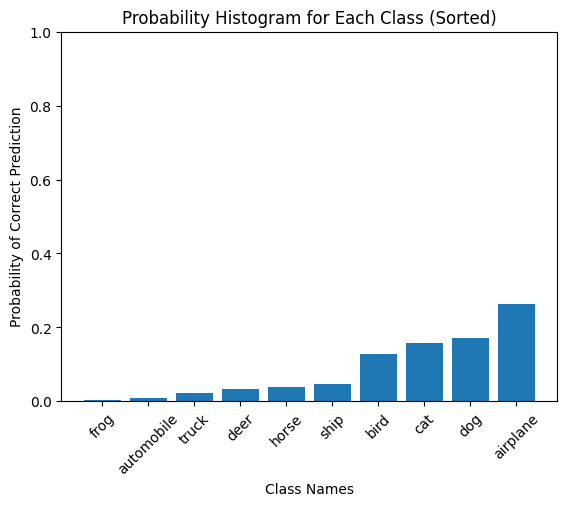



Accuracy on the test set after the final epoch: 8.75%
Analysis after epoch 20
Statistics of the weights for conv1:
Mean: -0.0008927599410526454
Standard Deviation: 0.08940348029136658
Minimum: -0.2967197597026825
Maximum: 0.32060009241104126
Statistics of the weights for conv2:
Mean: -0.0011778053594753146
Standard Deviation: 0.018791334703564644
Minimum: -0.12455286085605621
Maximum: 0.1551978588104248


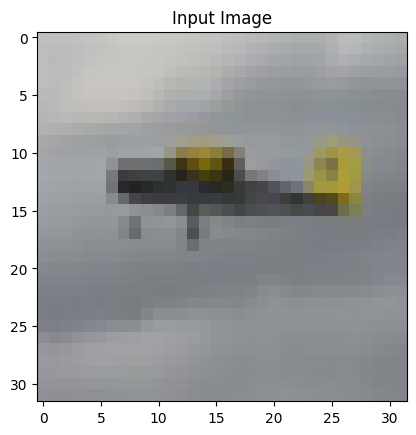

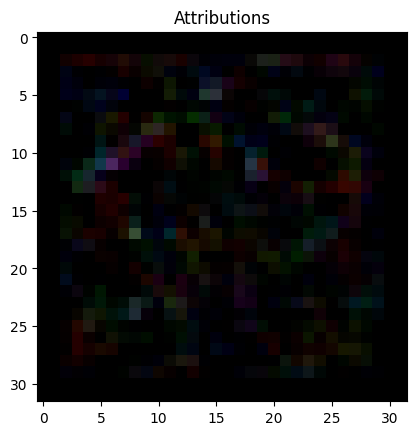

Convergence Delta: tensor([0.0306], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7502129673957825
Variance: 0.5683007836341858
Skewness: 1.3483114829561742
Kurtosis: 2.5482784834556362
Sparsity: 0.21943120216836734


Analysis for layer: conv2
Mean: 0.8204705119132996
Variance: 0.43955910205841064
Skewness: 0.7609764144944379
Kurtosis: 0.6068357824086017
Sparsity: 0.15480389030612246


Files already downloaded and verified






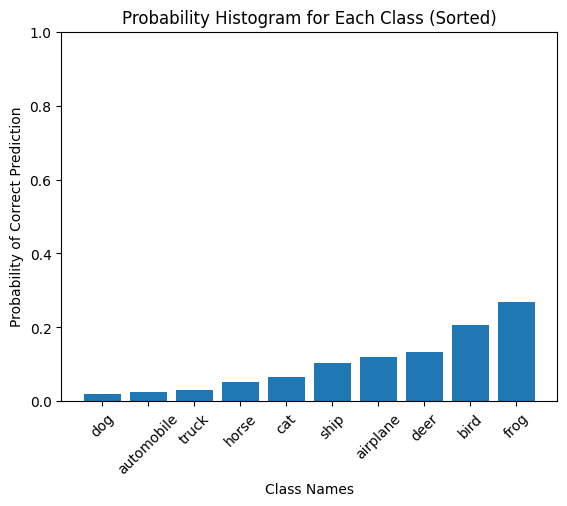



Accuracy on the test set after the final epoch: 10.26%
Analysis after epoch 25
Statistics of the weights for conv1:
Mean: -0.0009905633050948381
Standard Deviation: 0.09575627744197845
Minimum: -0.3335758447647095
Maximum: 0.38291826844215393
Statistics of the weights for conv2:
Mean: -0.0013616940705105662
Standard Deviation: 0.021022306755185127
Minimum: -0.14058224856853485
Maximum: 0.1845685839653015


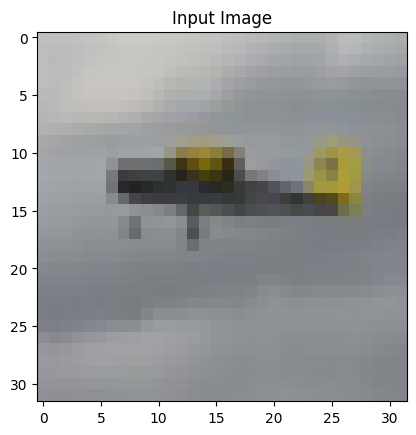

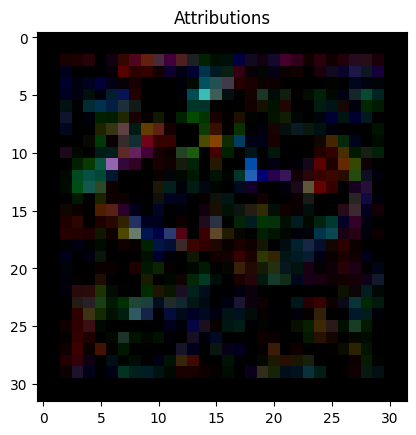

Convergence Delta: tensor([-0.0925], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.735196590423584
Variance: 0.5910486578941345
Skewness: 1.4658394614020118
Kurtosis: 3.0838115707334035
Sparsity: 0.23154057716836735


Analysis for layer: conv2
Mean: 0.8276508450508118
Variance: 0.4542640447616577
Skewness: 0.7861989945806552
Kurtosis: 0.6999451320026671
Sparsity: 0.15744100765306124


Files already downloaded and verified






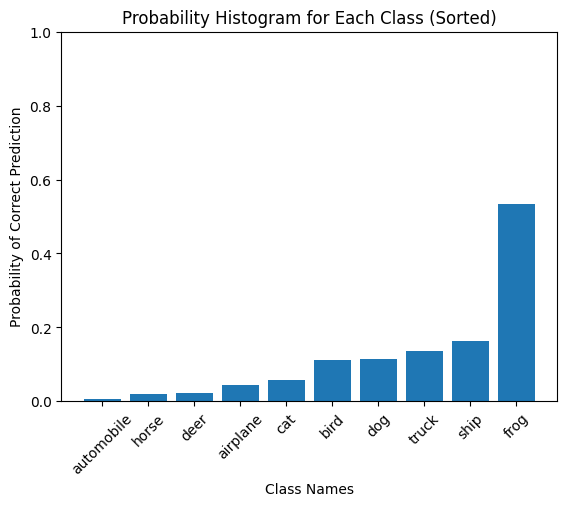



Accuracy on the test set after the final epoch: 12.12%
Analysis after epoch 30
Statistics of the weights for conv1:
Mean: -0.0011568758636713028
Standard Deviation: 0.09951706230640411
Minimum: -0.37550994753837585
Maximum: 0.4029731750488281
Statistics of the weights for conv2:
Mean: -0.0014213415561243892
Standard Deviation: 0.022301262244582176
Minimum: -0.1523718386888504
Maximum: 0.20087860524654388


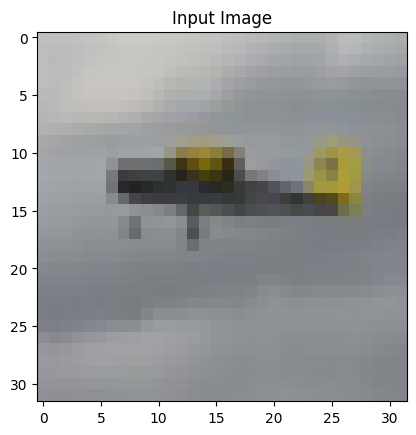

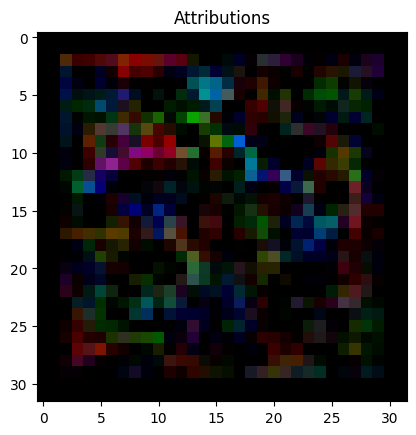

Convergence Delta: tensor([-0.0303], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7156829833984375
Variance: 0.5750873684883118
Skewness: 1.5383972678197793
Kurtosis: 3.5008284087531516
Sparsity: 0.2372441007653061


Analysis for layer: conv2
Mean: 0.816407322883606
Variance: 0.4328327178955078
Skewness: 0.7929871601066715
Kurtosis: 0.8006209848802857
Sparsity: 0.15337531887755101


Files already downloaded and verified






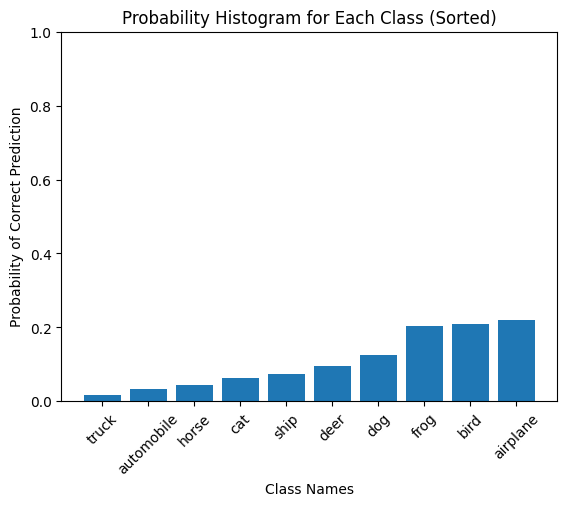



Accuracy on the test set after the final epoch: 10.84%


In [31]:
num_initializations = 1

for _ in range(num_initializations):

    sample_data, sample_target = next(iter(randY_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model3 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)


    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model3.conv1.weight.data
    # plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")
    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model3.conv2.weight.data
    # plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")
    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    for epoch in range(30):
      model3.train()
      for data, target in randY_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model3(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if (epoch + 1) % 10 == 0 or epoch==0:
        # Save activations
        model3.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in randY_subset_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model1(data)
                for layer_name, activation in model3.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        torch.save(model3.state_dict(), f'model_epoch_{epoch+1}.pth')

        # # Save activations
        # model1.eval()
        # activations = {}
        # with torch.no_grad():
        #     for data, _ in train_loader:  # Consider using a subset of data if full dataset is too large
        #         data = data.to(device)
        #         _ = model1(data)
        #         for layer_name, activation in model1.activations.items():
        #             if layer_name not in activations:
        #                 activations[layer_name] = []
        #             activations[layer_name].append(activation.cpu().numpy())

        # # Save activations to disk
        # with open(f'activations_epoch_{epoch+1}.pkl', 'wb') as f:
        #     pickle.dump(activations, f)

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")

        # Weight distribution and statistics
        weights = model3.conv1.weight.data
        # plot_weight_distribution(weights, f"Weight Distribution For Conv1 - Epoch {epoch + 1}")

        weightsConv2 = model3.conv2.weight.data
        # plot_weight_distribution(weightsConv2, f"Weight Distribution For Conv2- Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights for conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)


        # Attribution Analysis
        calculate_and_plot_attributions(model3, input_image, true_label)

        # Activation Analysis
        model3.eval()
        images, labels = next(iter(randY_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model3(images)
        for layer_name, activation in model3.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model3, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()

        print("\n")
        print("\n")

        # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)
        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]
        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()
        accuracy = calculate_accuracy(model3, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')
      scheduler.step()

In [32]:
import numpy as np
from scipy.linalg import svd

def centering_activations(acts):
    return acts - np.mean(acts, axis=1, keepdims=True)

def svd_reduction(acts, components):
    U, S, V = svd(acts, full_matrices=False)
    return np.dot(U[:, :components], np.diag(S[:components]))

# def cca_similarity(acts1, acts2):
#     U1, S1, _ = svd(acts1, full_matrices=False)
#     U2, S2, _ = svd(acts2, full_matrices=False)
#     D = np.dot(U1.T, U2)
#     return np.sum(np.diag(np.dot(np.diag(S1), D).dot(np.diag(S2)))) / (min(acts1.shape[0], acts2.shape[0]))

def cca_similarity(acts1, acts2):
    U1, _, _ = svd(acts1, full_matrices=False)
    U2, _, _ = svd(acts2, full_matrices=False)
    D = np.dot(U1.T, U2)

    # Compute singular values of D which are the canonical correlations
    _, s, _ = svd(D, full_matrices=False)

    return np.sum(s) / min(acts1.shape[0], acts2.shape[0])


def compute_svcca_similarity(activations1_list, activations2_list, components=20):
    # Concatenate activations from different batches into a single array
    activations1 = np.concatenate(activations1_list, axis=0)
    activations2 = np.concatenate(activations2_list, axis=0)

    # Reshape the activations to 2D if necessary
    if len(activations1.shape) > 2:
        activations1 = activations1.reshape(activations1.shape[0], -1).T
    if len(activations2.shape) > 2:
        activations2 = activations2.reshape(activations2.shape[0], -1).T

    # Center the activations
    centered_acts1 = centering_activations(activations1)
    centered_acts2 = centering_activations(activations2)

    # SVD Reduction
    svd_acts1 = svd_reduction(centered_acts1, components)
    svd_acts2 = svd_reduction(centered_acts2, components)

    # Compute CCA Similarity
    similarity = cca_similarity(svd_acts1, svd_acts2)

    return similarity


In [34]:
for epoch in (1,10,20,30):
    with open(f'model1_activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_actual = pickle.load(f)
    with open(f'model2_activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_random_input = pickle.load(f)
    with open(f'activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_random_labels = pickle.load(f)

    # print(len(activations_actual['conv1'][0]))

    for layer in ['conv1', 'conv2']:
        svcca_score_actual_vs_random_input = compute_svcca_similarity(activations_actual[layer], activations_random_input[layer])
        svcca_score_actual_vs_random_labels = compute_svcca_similarity(activations_actual[layer], activations_random_labels[layer])

        print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Input: {svcca_score_actual_vs_random_input}")
        print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Labels: {svcca_score_actual_vs_random_labels}")

64
Epoch 1, Layer conv1 - SVCCA Actual vs. Random Input: 2.5643165014228042e-05
Epoch 1, Layer conv1 - SVCCA Actual vs. Random Labels: 7.410834030229218e-05
Epoch 1, Layer conv2 - SVCCA Actual vs. Random Input: 0.00012225959982190812
Epoch 1, Layer conv2 - SVCCA Actual vs. Random Labels: 0.00017148933848556207
64
Epoch 10, Layer conv1 - SVCCA Actual vs. Random Input: 2.8768078405029918e-05
Epoch 10, Layer conv1 - SVCCA Actual vs. Random Labels: 7.80048479839247e-05
Epoch 10, Layer conv2 - SVCCA Actual vs. Random Input: 0.0001094301987667473
Epoch 10, Layer conv2 - SVCCA Actual vs. Random Labels: 0.00015305924172304115
64
Epoch 20, Layer conv1 - SVCCA Actual vs. Random Input: 2.714107535323318e-05
Epoch 20, Layer conv1 - SVCCA Actual vs. Random Labels: 8.630091438488084e-05
Epoch 20, Layer conv2 - SVCCA Actual vs. Random Input: 0.00011462772379116136
Epoch 20, Layer conv2 - SVCCA Actual vs. Random Labels: 0.000132710726893678
64
Epoch 30, Layer conv1 - SVCCA Actual vs. Random Input: 3.1